In [1]:
from tensorflow.keras.models import load_model
from clean import downsample_mono, envelope
from kapre.time_frequency import STFT, Magnitude, ApplyFilterbank, MagnitudeToDecibel
from sklearn.preprocessing import LabelEncoder
import numpy as np
from glob import glob
import argparse
import os
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Predict Real-world data based on clean-data trained model

In [7]:
model = load_model("npy_formal_dataset/model/lstm_overlapping_07272022.h5")
src_root = "npy_formal_dataset/test/"
npy_paths = glob('{}/**'.format(src_root), recursive=True)
npy_paths = sorted([x.replace(os.sep, '/') for x in npy_paths if "test.npy" in x])
print(npy_paths)
test_data = []
y_true_labels = []
for i in npy_paths:
    #print(np.load(i).shape)
    test_data.append(np.abs(np.load(i)))
    cur_cls = os.path.split(i)[0].split('/')[-1]
    cur_label = [cur_cls for i in range(np.load(i).shape[0])]
    y_true_labels += cur_label
test_data = np.stack(test_data)
y_true_labels = np.stack(y_true_labels)
test_data = test_data.reshape(test_data.shape[0]*test_data.shape[1],test_data.shape[2],test_data.shape[3],1)
print(test_data.shape)
print(y_true_labels.shape)
for i in range(test_data.shape[0]):
    test_data[i] /= test_data[i].max()

['npy_formal_dataset/test/faucet/test.npy', 'npy_formal_dataset/test/hairdryer/test.npy', 'npy_formal_dataset/test/hood/test.npy', 'npy_formal_dataset/test/washbasin/test.npy']
(640, 23, 641, 1)
(640,)


In [9]:
cls = sorted(os.listdir(src_root))
print(cls)
y_pred = model.predict(test_data)
y_pred_le = np.argmax(y_pred,axis=1)
y_pred_labels = [cls[i] for i in y_pred_le]

['faucet', 'hairdryer', 'hood', 'washbasin']


In [4]:
model = load_model("npy_augmented_real/lstm_overlapping_4_8k_40k.h5")
test_paths1 = glob('{}/**'.format("npy_augmented_real/hairdryer_washbasin_8k_40k/"), recursive=True)
test_paths2 = glob('{}/**'.format("npy_augmented_real/hood_faucet_8k_40k/"), recursive=True)
test_paths = test_paths1 + test_paths2
test_paths = [x.replace(os.sep, '/') for x in test_paths if 'Test' in x]
print(test_paths)
test_data = []
y_true_labels = []
for i in test_paths:
    #print(np.load(i).shape)
    test_data.append(np.abs(np.load(i)))
    cur_cls = os.path.split(i)[-1].split('_')[1]
    cur_label = [cur_cls for i in range(np.load(i).shape[0])]
    y_true_labels += cur_label
test_data = np.stack(test_data)
y_true_labels = np.stack(y_true_labels)
test_data = test_data.reshape(test_data.shape[0]*test_data.shape[1],test_data.shape[2],test_data.shape[3],1)
print(test_data.shape)
for i in range(test_data.shape[0]):
    test_data[i] /= test_data[i].max()

['npy_augmented_real/hairdryer_washbasin_8k_40k/Real_hairdryer_Test.npy', 'npy_augmented_real/hairdryer_washbasin_8k_40k/Real_washbasin_Test.npy', 'npy_augmented_real/hood_faucet_8k_40k/Real_faucet_Test.npy', 'npy_augmented_real/hood_faucet_8k_40k/Real_hood_Test.npy']
(320, 23, 641, 1)


In [6]:
cls = sorted(set(y_true_labels))
y_pred = model.predict(test_data)
y_pred_le = np.argmax(y_pred,axis=1)
y_pred_labels = [cls[i] for i in y_pred_le]

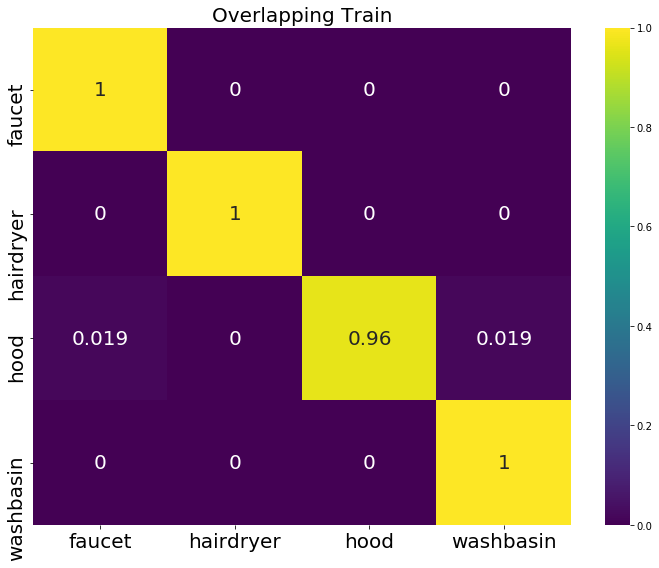

In [11]:
conf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=cls,normalize='true')
df_cm = pd.DataFrame(conf_mat, index = cls,
                     columns = cls)
plt.figure(figsize = (10,8),tight_layout=True)
plt.title('Overlapping Train',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
hm = sns.heatmap(df_cm, annot=True, cmap='viridis',annot_kws={"size": 20})
fig = hm.get_figure()
fig.savefig("1_2.jpg",dpi=100)
plt.show()

## Predict Real-world data based on augmented-data trained model

In [3]:
model = load_model("npy_augmented_real/hood_faucet/lstm_overlapping.h5")
test_paths = glob('{}/**'.format("npy_augmented_real/hood_faucet/"), recursive=True)
test_paths = sorted([x.replace(os.sep, '/') for x in test_paths if 'Test' in x])
print(test_paths)
test_L = np.abs(np.load(test_paths[0]))
label_L = np.stack(["faucet" for i in range(test_L.shape[0])])
test_R = np.abs(np.load(test_paths[1]))
label_R = np.stack(["hood" for i in range(test_R.shape[0])])
test_data = np.concatenate((test_L,test_R),axis=0)
test_data = test_data.reshape((*test_data.shape,1))
print(test_data.shape)
y_true_labels = np.concatenate((label_L,label_R))
print(y_true_labels.shape)
for i in range(test_data.shape[0]):
    test_data[i] /= test_data[i].max()

['npy_augmented_real/hood_faucet/Real_faucet_Test.npy', 'npy_augmented_real/hood_faucet/Real_hood_Test.npy']
(160, 23, 381, 1)
(160,)


In [4]:
cls = sorted(set(y_true_labels))
y_pred = model.predict(test_data)
y_pred_le = np.argmax(y_pred,axis=1)
y_pred_labels = [cls[i] for i in y_pred_le]
print(cls)

['faucet', 'hood']


In [5]:
print(y_pred_labels)

['faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'faucet', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood', 'hood',

In [6]:
print(y_true_labels)

['faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet'
 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet'
 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet'
 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet'
 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet'
 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet'
 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet'
 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet'
 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet'
 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet' 'faucet'
 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood'
 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood'
 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood'
 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 'hood' 

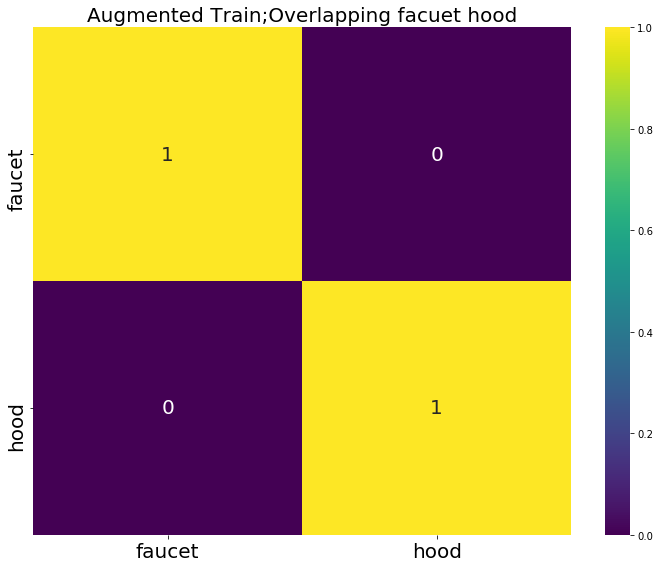

In [7]:
conf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=cls,normalize='true')
df_cm = pd.DataFrame(conf_mat, index = cls,
                     columns = cls)
plt.figure(figsize = (10,8),tight_layout=True)
plt.title('Augmented Train;Overlapping facuet hood',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
hm = sns.heatmap(df_cm, annot=True, cmap='viridis',annot_kws={"size": 20})
fig = hm.get_figure()
fig.savefig("Confusion_Only_Overlapping.jpg",dpi=100)
plt.show()

## Only for random test

In [6]:
model = load_model("models/conv2d_ultarmic_4.h5")
src_paths = "npy_overlapping/rough_ica.npy"
src = np.load(src_paths)
src = src.reshape(*src.shape,1)
src1 = src[:,0,1:-1,:,:]
src2 = src[:,1,1:-1,:,:]
re1 = model.predict(src1)
re_pred_idx = np.argmax(re1,axis=1)

In [7]:
re_pred_labels = [cls[i] for i in re_pred_idx]
print(re_pred_idx)

[2 0 0 2 0 2 2 2 2 0 2 0 2 0 0 1 1 1]


In [8]:
re2 = model.predict(src2)
re_pred_idx = np.argmax(re2,axis=1)
re_pred_labels = [cls[i] for i in re_pred_idx]
print(re_pred_idx)

[0 2 2 0 2 2 2 2 2 0 0 2 0 2 2 1 2 1]


In [9]:
cls

['Cello', 'Clarinet', 'Flute', 'None']

## Check GSC performance

In [5]:
model = load_model("models/conv2d_ultarmic_4.h5")
src_paths = glob('{}/**'.format("npy_overlapping"), recursive=True)
test_paths = sorted([x.replace(os.sep, '/') for x in src_paths if ('GSC' in x) and ('label' not in x)])
label_paths = sorted([x.replace(os.sep, '/') for x in src_paths if ('GSC_label' in x)])
test_data = np.load(test_paths[0])
test_data = test_data[:,2:-1,:]
y_true_labels = np.load(label_paths[0])
print(test_data.shape)
cls = sorted(set(y_true_labels))
cls.append('None')
le = LabelEncoder()
le.fit(cls)
test_data = test_data.reshape(*test_data.shape,1)
print(test_data.shape)
y_pred = model.predict(test_data)
y_pred_idx = np.argmax(y_pred,axis=1)
y_pred_labels = [cls[i] for i in y_pred_idx]

(130, 48, 1921)
(130, 48, 1921, 1)


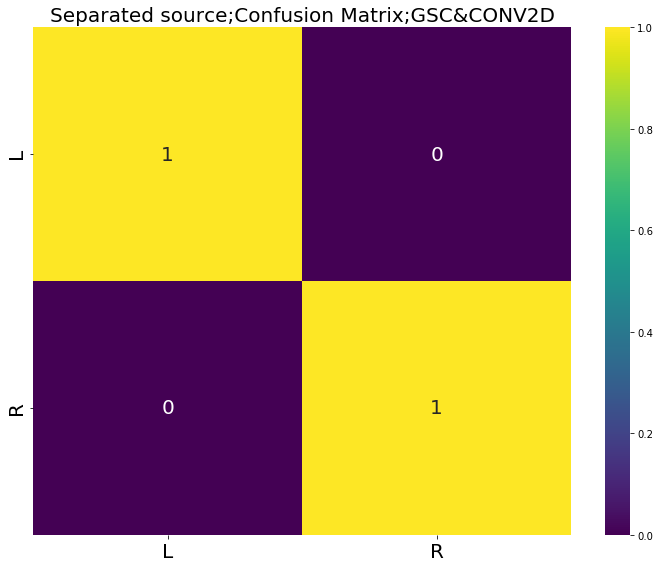

In [15]:
conf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=cls,normalize='true')
df_cm = pd.DataFrame(conf_mat, index = cls,
                     columns = cls)
plt.figure(figsize = (10,8),tight_layout=True)
plt.title('Separated source;Confusion Matrix;GSC&CONV2D',fontsize=20)
hm = sns.heatmap(df_cm, annot=True, cmap='viridis',annot_kws={"size": 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig = hm.get_figure()
#fig.savefig("Separated_cm_conv2d_4_GSC.jpg",dpi=100)
plt.show()

## Only read data but no label npy

In [4]:
model = load_model("models/conv2d_ultarmic_4.h5")
test_paths = glob('{}/**'.format("npy_overlapping"), recursive=True)
test_paths = sorted([x.replace(os.sep, '/') for x in test_paths if '.npy' in x])

wav_paths = glob('{}/**'.format("npy_files"), recursive=True)
wav_paths = sorted([x.replace(os.sep, '/') for x in wav_paths if ('Test_with' in x)])
print(wav_paths)
labels = np.load(wav_paths[1])
cls = sorted(set(labels))

le = LabelEncoder()
le.fit(cls)

y_pred_labels = []
y_true_labels = []
for path in test_paths:
    test_data = np.load(path)
    assert(test_data.dtype == np.complex64)
    num_instance = test_data.shape[0]
    dim_instance = test_data.shape[1:]
    #print("Number of Testing instance for each object:",num_instance)
    #print("Dimension of each instance:",dim_instance)
    test_data = test_data.reshape((*test_data.shape,1))
    test_data = test_data[:,1:-1,:,:]
    print(test_data.shape)
    assert(test_data.shape[1]==48 and test_data.shape[2]==1921)
    cur_label = os.path.split(path)[-1].split("_")[1]
    mix_with = os.path.split(path)[-1].split("_")[2].split(".")[0]
    print("cur_label:",cur_label," ",str(le.transform([cur_label])),"Mixed with:",mix_with," ",str(le.transform([mix_with])))
    y_pred = model.predict(test_data)
    y_pred_le = np.argmax(y_pred,axis=1)
    print(y_pred_le)
    for i in range(len(y_pred_le)):
        y_pred_labels.append(cls[y_pred_le[i]])
        y_true_labels.append(cur_label)

['npy_files/Test_with_4.npy', 'npy_files/Test_with_4_label.npy']
(18, 48, 1921, 1)
cur_label: Cello   [0] Mixed with: Clarinet   [1]
[2 0 0 2 2 2 2 2 2 0 0 2 0 2 2 2 2 2]
(18, 48, 1921, 1)
cur_label: Cello   [0] Mixed with: Flute   [2]
[2 2 0 2 2 2 0 0 0 0 2 0 0 0 0 2 0 0]
(18, 48, 1921, 1)
cur_label: Clarinet   [1] Mixed with: Cello   [0]
[2 2 2 2 2 1 1 1 1 2 2 2 2 2 1 1 1 0]
(29, 48, 1921, 1)
cur_label: Clarinet   [1] Mixed with: Flute   [2]
[2 2 2 2 0 2 1 1 1 1 2 1 1 1 2 1 2 1 1 1 2 2 2 2 2 2 1 1 2]
(18, 48, 1921, 1)
cur_label: Flute   [2] Mixed with: Cello   [0]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
(29, 48, 1921, 1)
cur_label: Flute   [2] Mixed with: Clarinet   [1]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


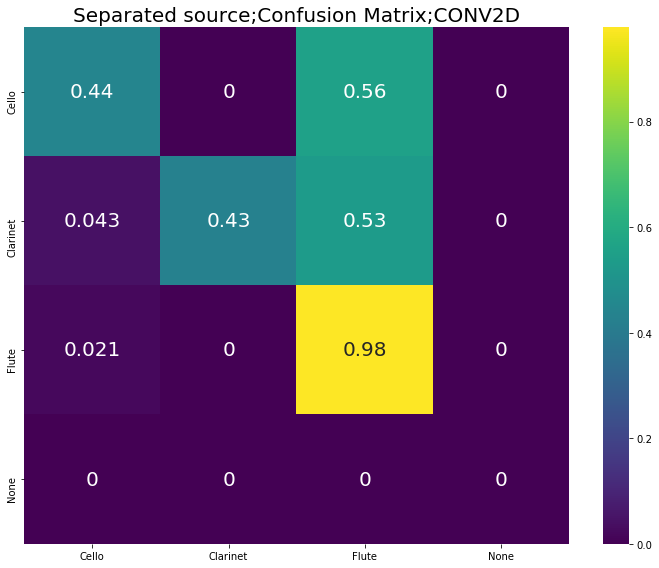

In [6]:
conf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=cls,normalize='true')
df_cm = pd.DataFrame(conf_mat, index = cls,
                     columns = cls)
plt.figure(figsize = (10,8),tight_layout=True)
plt.title('Separated source;Confusion Matrix;CONV2D',fontsize=20)
hm = sns.heatmap(df_cm, annot=True, cmap='viridis',annot_kws={"size": 20})
fig = hm.get_figure()    
#fig.savefig("Separated_cm_conv2d_4.jpg",dpi=100)
plt.show()

In [10]:
f1_score(y_true_labels, y_pred_labels, average='micro')

0.6307692307692307

In [15]:
model = load_model("models/conv2d_ultarmic_4.h5")
test_paths = glob('{}/**'.format("npy_files"), recursive=True)
test_paths = sorted([x.replace(os.sep, '/') for x in test_paths if ('Test_with' in x)])
print(test_paths)
test_data = np.abs(np.load(test_paths[0]))
assert(test_data.dtype != np.complex64)
print(test_data.dtype)
print(test_data.shape)
num_instance = test_data.shape[0]
dim_instance = test_data.shape[1:]
print("Number of Testing instance for each object:",num_instance)
print("Dimension of each instance:",dim_instance)
test_data = test_data.reshape((*test_data.shape,1))
print(test_data.shape)

['npy_files/Test_with_4.npy', 'npy_files/Test_with_4_label.npy']
float32
(104, 48, 1921)
Number of Testing instance for each object: 104
Dimension of each instance: (48, 1921)
(104, 48, 1921, 1)


In [16]:
labels = np.load(test_paths[1])
le = LabelEncoder()
y_true = le.fit_transform(labels)
print(y_true)
y_pred = model.predict(test_data)
y_pred_le = np.argmax(y_pred,axis=1)
cls = sorted(set(labels))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [17]:
model.predict(test_data[99:102])

array([[1.0776753e-03, 1.0360398e-03, 1.9069141e-03, 9.9597931e-01],
       [8.0212043e-04, 1.0873864e-03, 1.1336420e-03, 9.9697685e-01],
       [8.8308821e-04, 1.0029995e-03, 9.8417816e-04, 9.9712974e-01]],
      dtype=float32)

In [18]:
y_pred_labels = [cls[x] for x in y_pred_le]
y_true_labels = [cls[x] for x in y_true]

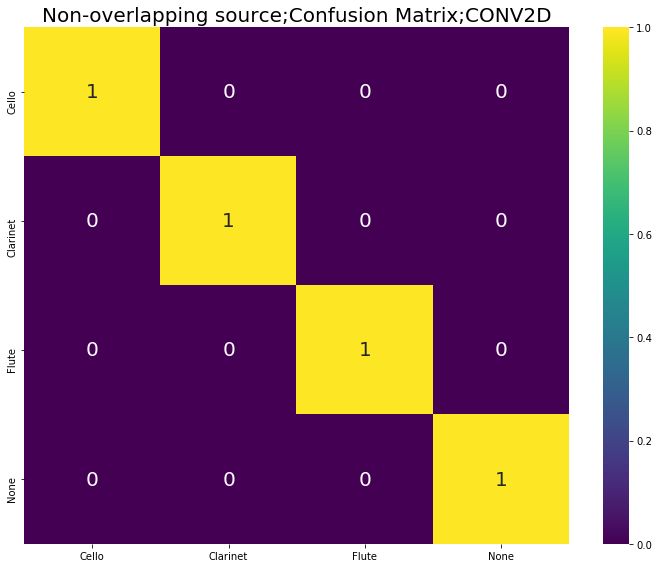

In [19]:
conf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=cls,normalize='true')
df_cm = pd.DataFrame(conf_mat, index = cls,
                     columns = cls)
plt.figure(figsize = (10,8),tight_layout=True)
plt.title('Non-overlapping source;Confusion Matrix;CONV2D',fontsize=20)
hm = sns.heatmap(df_cm, annot=True, cmap='viridis',annot_kws={"size": 20})
fig = hm.get_figure()    
fig.savefig("nonlap_cm_conv2d_4.jpg",dpi=100)
plt.show()

In [65]:
model = load_model("models/lstm_ultarmic.h5")
npy_paths = glob('{}/**'.format("npy_files_predict"), recursive=True)
npy_paths = sorted([x.replace(os.sep, '/') for x in npy_paths if 'DASICA.npy' in x])
test_data = []
for path in npy_paths:
    test_data.append(np.load(path))
test_data = np.stack(test_data)
print(test_data.shape)
num_object = test_data.shape[0]
num_instance = test_data.shape[1]
dim_instance = test_data.shape[2:]
print("Number of Testing Object:",num_object)
print("Number of Testing instance for each object:",num_instance)
print("Dimension of each instance:",dim_instance)
test_data = test_data.reshape((*test_data.shape,1))
print(test_data.shape)

(2, 100, 36, 234)
Number of Testing Object: 2
Number of Testing instance for each object: 100
Dimension of each instance: (36, 234)
(2, 100, 36, 234, 1)


In [66]:
classes = sorted(os.listdir("npy_files_predict"))
le = LabelEncoder()
le.fit(classes)
print(classes)
labels = []
for i in range(num_object):
    for j in range(num_instance):
        labels.append(classes[i])
y_true = le.fit_transform(labels)
print(y_true)

['Drill', 'Drill_Test1.npy', 'Shaver']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [71]:
y_pred = model.predict(test_data[1,:,:,:,:])

In [72]:
y_mean = np.mean(y_pred, axis=0)
print(y_mean)

[0.99421227 0.00578771]


In [69]:
train_data = np.load("stft_object_clipping.npy")
train_data = train_data.reshape((*train_data.shape,1))
print(train_data.shape)

(2, 300, 36, 234, 1)


In [70]:
y_pred = model.predict(train_data[1,:,:,:,:])
y_mean = np.mean(y_pred, axis=0)
print(y_mean)

[0.00108265 0.9989175 ]
